# Gradient extremal on sphere — SimplePotential (interactive)

This notebook is a direct conversion of `examples/SimplePotential_On_Sphere.py` so you can run and step through the computation interactively. It inserts the repository `src/` directory onto `sys.path` so the local package `gradient_extremals_on_manifolds` can be imported without installing the package.

Notes: the original script uses `jax`, `mayavi` and other libraries. If `mayavi` isn't available the 3D plotting cells will be skipped.

## Dependencies
Install the required packages in the Python environment you plan to use for this notebook. On Windows you may prefer a conda environment for `mayavi`/`vtk` support. Example (pip):

```

python -m pip install -U pip setuptools wheel
python -m pip install jax jaxlib matplotlib scipy numpy mayavi
```

If you run into issues installing `jax` on Windows, consult the official JAX installation instructions (they often require a specific `jaxlib`). For `mayavi` it's often easier to use `conda` (e.g. `conda install -c conda-forge mayavi`).

In [1]:
# Ensure the repository `src/` directory is on sys.path so local imports work
import os
import sys
_THIS_DIR = os.path.dirname(__file__) if '__file__' in globals() else os.getcwd()
_REPO_ROOT = os.path.abspath(os.path.join(_THIS_DIR, '..'))
_SRC_DIR = os.path.join(_REPO_ROOT, 'src')
if _SRC_DIR not in sys.path:
    sys.path.insert(0, _SRC_DIR)

print('Inserted to sys.path:', _SRC_DIR)

Inserted to sys.path: c:\Users\roshr\gradient_extremals_on_manifolds\src


In [2]:
# Imports (guard mayavi so the notebook can run without it)
from SimplePotential import SimplePotential
from utils import plot_spherical_potential, plot_points3d

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.linalg import eigvalsh

# mayavi is optional for 3D plotting — guard the import
try:
    from mayavi import mlab
    _HAS_MAYAVI = True
except Exception as _err:
    print('mayavi import failed:', _err)
    _HAS_MAYAVI = False

from gradient_extremals_on_manifolds.Continuation import Continuation

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
# Imports (guard mayavi so the notebook can run without it)
from SimplePotential import SimplePotential
from utils import plot_spherical_potential, plot_points3d

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.linalg import eigvalsh

# # mayavi is optional for 3D plotting — guard the import
# try:
#     from mayavi import mlab
#     _HAS_MAYAVI = True
# except Exception as _err:
#     print('mayavi import failed:', _err)
#     _HAS_MAYAVI = False

from gradient_extremals_on_manifolds.Continuation import Continuation

In [3]:
# Plot font settings (same as the script)
plt.close()
plt.rcParams['text.latex.preamble'] = r"\usepackage{lmodern}"
params = {'text.usetex': True, 'font.size': 18}
plt.rcParams.update(params)

In [4]:
# Create the potential and compute fixed points
simple_potential = SimplePotential()

fixed_points = simple_potential.get_fixed_points(manifold=True)
fixed_points_2D = jax.vmap(simple_potential.phi)(fixed_points)

fixed_points, fixed_points_2D[:5]  # show a small preview

(Array([[ 0.57735926, -0.5773412 ,  0.5773504 ],
        [ 1.        ,  0.        ,  0.        ],
        [ 0.5773545 ,  0.57734233, -0.577354  ],
        [ 0.        , -1.        ,  0.        ],
        [-0.5773545 , -0.57734233, -0.577354  ]], dtype=float32),
 Array([[ 1.366047  , -1.3660043 ],
        [ 1.        ,  0.        ],
        [ 0.36602724,  0.36601952],
        [ 0.        , -1.        ],
        [-0.36602724, -0.36601952]], dtype=float32))

In [5]:
# Build the left gradient extremal (same logic as the script)
initial = fixed_points_2D[0] + jnp.array([0.0, 0.005])
hes = simple_potential.hess(initial)
lam = eigvalsh(hes)[0]

gradient_extremal = Continuation(initial_point=jnp.array([initial[0], initial[1],
                                                          lam, simple_potential.potential(initial)]),
                                 functions=[simple_potential.lucia_phi,
                                            simple_potential.lucia_hessian_eq1,
                                            simple_potential.lucia_hessian_eq2],
                                 maxiter=580,
                                 verbose=0,
                                 tolerance=0.5,
                                 h=1E-1)

gradient_extremal.start()
gradient_extremal_points = gradient_extremal.getPoints()
len(gradient_extremal_points)

581

In [6]:
# Build the right gradient extremal
initial = fixed_points_2D[0] + jnp.array([-0.05, -0.01])
hes = simple_potential.hess(initial)
lam = eigvalsh(hes)[0]

gradient_extremal_right = Continuation(initial_point=jnp.array([initial[0], initial[1],
                                                                lam, simple_potential.potential(initial)]),
                                       functions=[simple_potential.lucia_phi,
                                                  simple_potential.lucia_hessian_eq1,
                                                  simple_potential.lucia_hessian_eq2],
                                       maxiter=550,
                                       verbose=0,
                                       tolerance=0.5,
                                       h=1E-1)

gradient_extremal_right.start()
gradient_extremal_rightpoints = gradient_extremal_right.getPoints()
len(gradient_extremal_rightpoints)

551

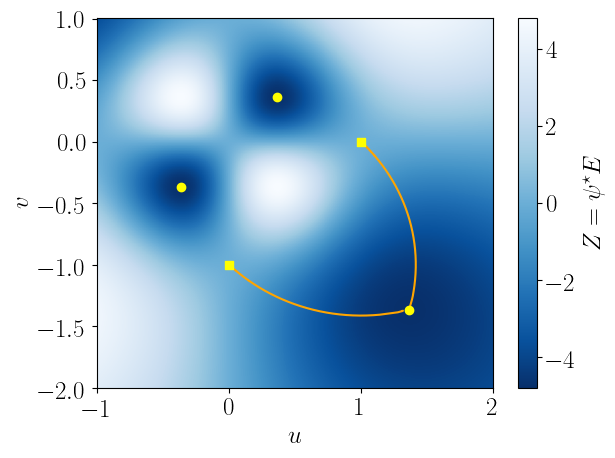

In [7]:
# 2D plotting with matplotlib
simple_potential.plot_color_mesh(colorbarTitle=r'$Z=\psi^\star E$')
plt.plot([p[0] for p in gradient_extremal_points], [p[1] for p in gradient_extremal_points], color='orange')
plt.plot([p[0] for p in gradient_extremal_rightpoints], [p[1] for p in gradient_extremal_rightpoints], color='orange')

plt.scatter(x=fixed_points_2D[[0,2,4],0], y=fixed_points_2D[[0,2,4],1], color='Yellow', zorder=15)
plt.scatter(x=fixed_points_2D[[1,3],0], y=fixed_points_2D[[1,3],1], color='Yellow', marker='s', s=40, zorder=20)
plt.xlabel(r'$u$')
plt.ylabel(r'$v$')
plt.show()

In [ ]:
# 3D plotting — only run if mayavi is available
if _HAS_MAYAVI:
    gradient_extremal_3D = jax.vmap(simple_potential.psi)(jnp.array(gradient_extremal_points)[:,0:2])
    gradient_extremal_right_3D = jax.vmap(simple_potential.psi)(jnp.array(gradient_extremal_rightpoints)[:,0:2])

    plot_spherical_potential(simple_potential.E)
    plot_points3d(gradient_extremal_3D, s=[1 for _ in range(len(gradient_extremal_points))], color=(1.0,0.65,0.0))
    plot_points3d(gradient_extremal_right_3D, s=[1 for _ in range(len(gradient_extremal_rightpoints))], color=(1.0,0.65,0.0))
    plot_points3d(fixed_points[[0,2,4],:], s=[1 for _ in range(len(fixed_points[[0,2,4],:]))], color=(1.0,1.0,0.0), mode='cube', scale_factor=0.05)
    plot_points3d(fixed_points[[1,3],:], s=[1 for _ in range(len(fixed_points[[1,3],:]))], color=(1.0,1.0,0.0), mode='sphere', scale_factor=0.05)
    mlab.show()
else:
    print('mayavi not available — skipping 3D plotting cells.')

---
**Notes:**
- If you plan to run many of the examples from this repo, I still recommend installing the package in editable mode:
```
python -m pip install -e .
```
- If you see errors about missing dependencies, install them in the same environment used by the notebook kernel.
- If you want I can also convert other example scripts into notebooks.